In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Python Libraries

In [ ]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
import numpy as np
import seaborn as sns
import re
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, auc

In [ ]:
#Initilizing the time function
start_time = time.time()

#### BERT Model Setup for Sentiment Analysis

This process begins by connecting to a TPU (Tensor Processing Unit) provided by Google Colab, which will significantly accelerate the training of the model.I then load our dataset, check for missing values, and visualize the distribution of sentiment labels to understand the balance of our classes.

In [ ]:
# Connectting to the TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
tpu_strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
df_bert_1 = pd.read_csv('/content/drive/MyDrive/BERT SCRIPT/Original_Data.csv')

# Checking for NaN values
nan_in_data = df_bert_1.isna().sum()
print(nan_in_data)

<ipython-input-5-f7df47d0c4c8>:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bert_1 = pd.read_csv('/content/drive/MyDrive/BERT SCRIPT/Original_Data.csv')


business                  0
review_title              0
date_of_experience        0
review_date               0
review_rating         28470
review_text               0
page_number               2
review_text_length        2
sentiment_polarity        2
sentiment_label           2
review_year               2
dtype: int64


In [ ]:
df_bert_1.drop('review_rating', axis=1, inplace=True)
df_bert_1.dropna(inplace=True)

In [ ]:
# Checking for NaN values
nan_in_data = df_bert_1.isna().sum()
print(nan_in_data)

business              0
review_title          0
date_of_experience    0
review_date           0
review_text           0
page_number           0
review_text_length    0
sentiment_polarity    0
sentiment_label       0
review_year           0
dtype: int64


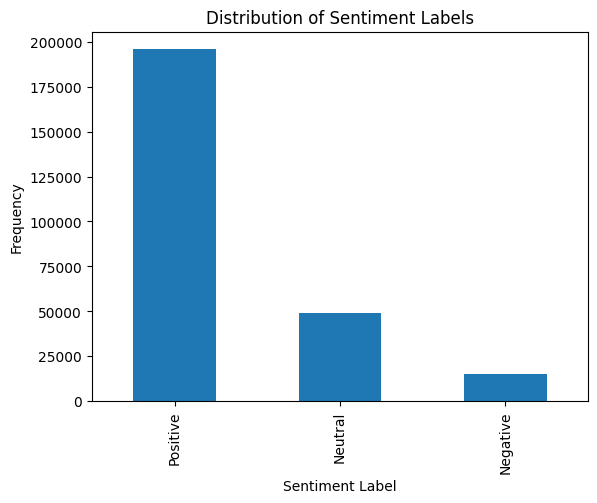

In [ ]:
# Plotting to check data balance
class_counts = df_bert_1['sentiment_label'].value_counts()
class_counts.plot(kind='bar')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.show()

#### Preparing Data for BERT Training
To train the BERT model, I organized the data into training and validation sets using a random split, reserving 30% of the data for validation. Given the class imbalance in the dataset, I applied oversampling to the training data to ensure that the model doesn't become biased towards the majority class.

After resampling, I plotted the distribution of sentiment labels to confirm that the classes are now balanced. I then proceeded to encode the text data into a format suitable for BERT, which involves tokenization and attention mask generation. Each text review is truncated or padded to a maximum length of 512 tokens to meet BERT's input specifications.

With the text converted into BERT's input format, I created TensorFlow datasets that will feed data into the model in batches during training, ensuring efficient use of memory and processing power.

In [ ]:
# Splitting the data into training and validation sets
train_df, val_df = train_test_split(df_bert_1, test_size=0.3, random_state=42)

In [ ]:
# Resampling the training data
ros = RandomOverSampler(random_state=42)
train_df_resampled, train_labels_resampled = ros.fit_resample(train_df[['review_text']], train_df['sentiment_label'])

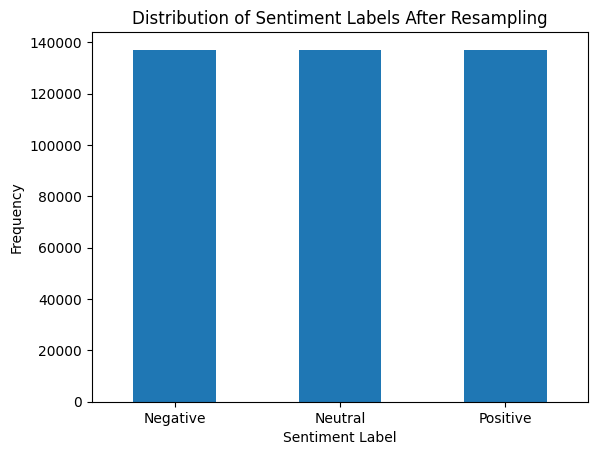

In [ ]:
# Assuming train_labels_resampled contains the resampled labels
label_counts = pd.Series(train_labels_resampled).value_counts()

# Plot the distribution
label_counts.plot(kind='bar')
plt.title('Distribution of Sentiment Labels After Resampling')
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'], rotation=0)  # Adjust the labels as per your dataset
plt.show()

In [ ]:
# Defining tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Function to convert examples to BERT features
def convert_example_to_feature(review, label):
    # Encode the text using the BERT tokenizer
    encoding = tokenizer.encode_plus(
        review, add_special_tokens=True, max_length=512, truncation=True,
        padding='max_length', return_attention_mask=True
    )
    # Converts label to int and return a dictionary with the encoded features and label
    return {
        'input_ids': encoding['input_ids'],
        'attention_mask': encoding['attention_mask'],
        'label': label
    }

In [ ]:
sentiment_label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

# Mapping the labels to integers
train_labels_resampled_int = train_labels_resampled.map(sentiment_label_mapping)
val_labels_int = val_df['sentiment_label'].map(sentiment_label_mapping)

In [ ]:
# Converting the training and validation data into features with integer labels
train_features = [convert_example_to_feature(text, label) for text, label in zip(train_df_resampled['review_text'], train_labels_resampled_int)]
val_features = [convert_example_to_feature(text, label) for text, label in zip(val_df['review_text'], val_labels_int)]

In [ ]:
#This function structures the data into a format that is compatible with BERT models in TensorFlow.
def map_features_to_model_inputs(features):
    # Initialize dictionaries to store input IDs and attention masks, and a list for labels
    inputs = {'input_ids': [], 'attention_mask': []}
    labels = []
    
     # Iterate over each feature in the provided list
    for feature in features:
        # Append the input ID and attention mask of each feature to the respective dictionary lists
        inputs['input_ids'].append(feature['input_ids'])
        inputs['attention_mask'].append(feature['attention_mask'])
        
         # Append the label of each feature to the labels list
        labels.append(feature['label'])
        
        
    # Return the structured data: input IDs, attention masks, and labels
    return (inputs, labels)

In [ ]:
# Convert features to model input format
train_inputs, train_labels = map_features_to_model_inputs(train_features)
val_inputs, val_labels = map_features_to_model_inputs(val_features)

In [ ]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(100).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_inputs, val_labels)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

#### Training the BERT Model

The model is instantiated and compiled within the scope of a TPU strategy to leverage the high computational power of TPUs, which significantly speeds up training. The BERT model is fine-tuned for a three-class classification task, corresponding to the sentiment labels in the dataset.

I used a combination of ModelCheckpoint and EarlyStopping callbacks during training. The ModelCheckpoint saves the best model weights based on the validation loss, allowing me to restore the best model state post-training. EarlyStopping is employed to halt training if the validation loss does not improve after a specified number of epochs, preventing overfitting.

Post-training, I save the model's structure and weights separately transferred the files to Google Drive for storage.

Finally, I plotted the learning curves for both accuracy and loss.

In [ ]:
with tpu_strategy.scope():
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])


# Defining ModelCheckpoint and EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

# ModelCheckpoint to save only weights
model_checkpoint = ModelCheckpoint(
    filepath='/tmp/bert_best_weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_dataset,
    epochs=4,
    validation_data=val_dataset,
    callbacks=[model_checkpoint, early_stopping],
    verbose=1
)


# After training, save the model structure and weights separately
model_structure = model.to_json()
with open("/tmp/bert_model_structure.json", "w") as json_file:
    json_file.write(model_structure)


# Copy the saved weights and structure to Google Drive
!cp /tmp/bert_best_weights.h5 "/content/drive/My Drive/"
!cp /tmp/bert_model_structure.json "/content/drive/My Drive/"

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
12848/12848 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0.9742
Epoch 1: val_loss improved from inf to 9.46529, saving model to /tmp/bert_best_weights.h5
12848/12848 [==============================] - 2237s 168ms/step - loss: 0.0704 - accuracy: 0.9742 - val_loss: 9.4653 - val_accuracy: 0.1900
Epoch 2/4
12848/12848 [==============================] - ETA: 0s - loss: 0.0495 - accuracy: 0.9828
Epoch 2: val_loss improved from 9.46529 to 9.28018, saving model to /tmp/bert_best_weights.h5
12848/12848 [==============================] - 2146s 167ms/step - loss: 0.0495 - accuracy: 0.9828 - val_loss: 9.2802 - val_accuracy: 0.1900
Epoch 3/4
12848/12848 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9873
Epoch 3: val_loss improved from 9.28018 to 8.00828, saving model to /tmp/bert_best_weights.h5
12848/12848 [==============================] - 2141s 167ms/step - loss: 0.0380 - accuracy: 0.9873 - val_loss: 8.0083 - val_accuracy: 0.1900
Epoch

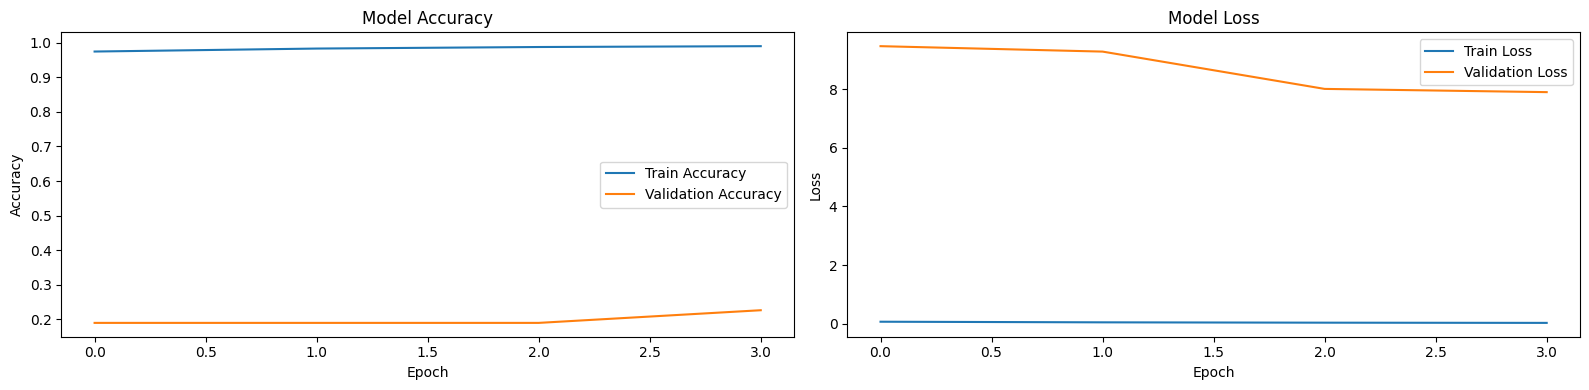

In [ ]:
# Plot learning curves
plt.figure(figsize=(16, 4))  # Increase the width of the combined plot

# Plot learning curves (accuracy)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot learning curves (loss)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()  # Adjust the layout
plt.show()  # Display the combined plot

#### Addressing Class Imbalance and overfitting observed

I computed class weights which are used during the training of the BERT model to ensure that minority classes contribute more to the loss, balancing their influence on the model's learning process. Subsequently, i repeated all the other steps used for the previous training.

In [ ]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_bert_1['sentiment_label']),
    y=df_bert_1['sentiment_label'].values
)

# Convert class_weights to a dictionary to pass it to Keras
class_weight_dict = {i : class_weights[i] for i,label in enumerate(np.unique(df_bert_1['sentiment_label']))}


In [ ]:
# Splitting the data into training and validation sets
train_df_2, val_df_2 = train_test_split(df_bert_1, test_size=0.3, random_state=42)

In [ ]:
train_df_2['sentiment_label'] = train_df_2['sentiment_label'].map(sentiment_label_mapping)
val_df_2['sentiment_label'] = val_df_2['sentiment_label'].map(sentiment_label_mapping)

In [ ]:
# Preparing features for input
train_features_2 = [convert_example_to_feature(text, label) for text, label in zip(train_df_2['review_text'], train_df_2['sentiment_label'])]
val_features_2 =[convert_example_to_feature(text, label) for text, label in zip(val_df_2['review_text'], val_df_2['sentiment_label'])]

In [ ]:
train_inputs_2, train_labels_2 = map_features_to_model_inputs(train_features_2)
val_inputs_2, val_labels_2 = map_features_to_model_inputs(val_features_2)

In [ ]:
# Creating TensorFlow datasets
train_dataset_2 = tf.data.Dataset.from_tensor_slices((train_inputs_2, train_labels_2)).shuffle(100).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_datase_2 = tf.data.Dataset.from_tensor_slices((val_inputs_2, val_labels_2)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Clearing the TensorFlow session
tf.keras.backend.clear_session()

# Define the BERT model
with tpu_strategy.scope():  
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

# Defining callbacks for early stopping and model checkpointing
early_stopping_1 = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
model_checkpoint_1 = ModelCheckpoint(filepath='/tmp/bert_best_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)

# Training the model with class weights
history_1 = model.fit(train_dataset_2, epochs=4, validation_data=val_datase_2, callbacks=[model_checkpoint_1, early_stopping_1], class_weight=class_weight_dict, verbose=1)

model_structure_1 = model.to_json()
with open("/tmp/bert_model_structure.json", "w") as json_file:
    json_file.write(model_structure)

# Save the weights
model.save_weights('/tmp/bert_best_weights.h5')

# Copy the saved weights and structure to Google Drive
!cp /tmp/bert_best_weights.h5 "/content/drive/My Drive/"
!cp /tmp/bert_model_structure.json "/content/drive/My Drive/"

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
5686/5686 [==============================] - ETA: 0s - loss: 0.2801 - accuracy: 0.9170
Epoch 1: val_loss improved from inf to 0.13035, saving model to /tmp/bert_best_weights.h5
5686/5686 [==============================] - 1146s 188ms/step - loss: 0.2801 - accuracy: 0.9170 - val_loss: 0.1303 - val_accuracy: 0.9538
Epoch 2/4
5686/5686 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.9521
Epoch 2: val_loss did not improve from 0.13035
5686/5686 [==============================] - 1022s 180ms/step - loss: 0.1543 - accuracy: 0.9521 - val_loss: 0.1421 - val_accuracy: 0.9494
Epoch 3/4
5686/5686 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 0.9625
Epoch 3: val_loss improved from 0.13035 to 0.10601, saving model to /tmp/bert_best_weights.h5
5686/5686 [==============================] - 1023s 180ms/step - loss: 0.1156 - accuracy: 0.9625 - val_loss: 0.1060 - val_accuracy: 0.9633
Epoch 4/4
5686/5686 [==============================] - ETA: 0s -

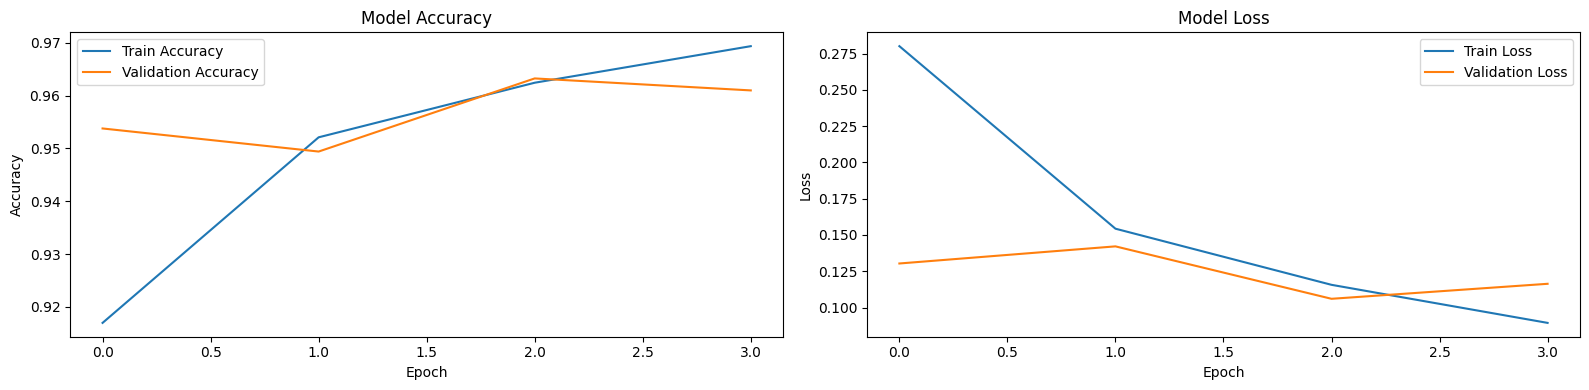

In [ ]:
# Plotting learning curves
plt.figure(figsize=(16, 4)) 

# Plotting learning curves (accuracy)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(history_1.history['accuracy'], label='Train Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plotting learning curves (loss)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()  # Adjusting the layout
plt.show()  # Displaying the combined plot

#### Model Evaluation and Performance Analysis

After training the BERT model, I proceeded to evaluate its performance on the validation dataset. This step involves making predictions, comparing these predictions against the true labels, and analyzing the results through various metrics.

I first used the model to predict sentiment labels for the validation set and then created a confusion matrix to visualize the model’s performance in correctly classifying each sentiment class. The confusion matrix provides a clear picture of the model’s strengths and weaknesses in classifying different classes.

Next, I generated a classification report, which includes precision, recall, and F1-score for each class. This report gives a detailed understanding of the model's classification abilities.

I also computed and plotted ROC (Receiver Operating Characteristic) curves and calculated the AUC (Area Under Curve) for each class as well as micro and macro averages. ROC curves are a powerful tool to assess the model's ability to distinguish between classes.

Finally, I analyze the model’s training and validation accuracy over epochs and report the final training and validation accuracy. This analysis helps to understand the learning trajectory of the model and its performance stability.

2437/2437 [==============================] - 147s 55ms/step


Exception ignored in: <function Executor.__del__ at 0x78c664e56a70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


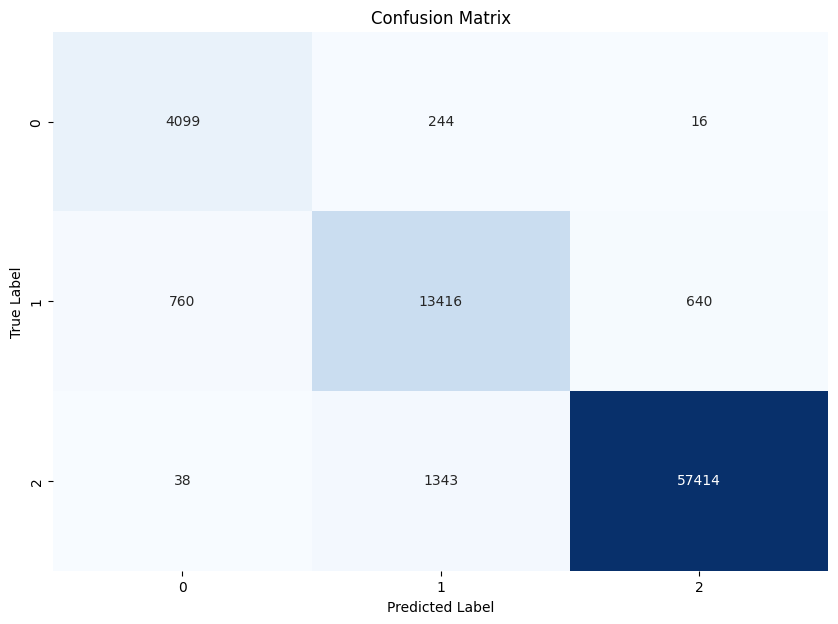

              precision    recall  f1-score   support

    Negative       0.84      0.94      0.89      4359
     Neutral       0.89      0.91      0.90     14816
    Positive       0.99      0.98      0.98     58795

    accuracy                           0.96     77970
   macro avg       0.91      0.94      0.92     77970
weighted avg       0.96      0.96      0.96     77970



In [ ]:
# Make predictions
val_pred_probabilities = model.predict(val_datase_2)
val_preds = np.argmax(val_pred_probabilities.logits, axis=1)

# True labels
val_true = np.concatenate([y.numpy() for x, y in val_datase_2], axis=0)

# Generate confusion matrix
cm = confusion_matrix(val_true, val_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
print(classification_report(val_true, val_preds, target_names=['Negative', 'Neutral', 'Positive']))


In [ ]:
# Accessing the history dictionary
history_dict = history_1.history

# Training accuracy per epoch
train_acc = history_dict['accuracy']
print(f'Train Accuracy per epoch: {train_acc}')

# Validation accuracy per epoch
val_acc = history_dict['val_accuracy']
print(f'Validation Accuracy per epoch: {val_acc}')


Train Accuracy per epoch: [0.916961669921875, 0.9521129131317139, 0.9624521732330322, 0.9693779945373535]
Validation Accuracy per epoch: [0.9537898898124695, 0.94941645860672, 0.9632679224014282, 0.9609978199005127]


In [ ]:
# Final training accuracy
final_train_acc = train_acc[-1]
print(f'Final Train Accuracy: {final_train_acc:.4f}')

# Final validation accuracy
final_val_acc = val_acc[-1]
print(f'Final Validation Accuracy: {final_val_acc:.4f}')


Final Train Accuracy: 0.9694
Final Validation Accuracy: 0.9610


Exception ignored in: <function Executor.__del__ at 0x78c664e56a70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


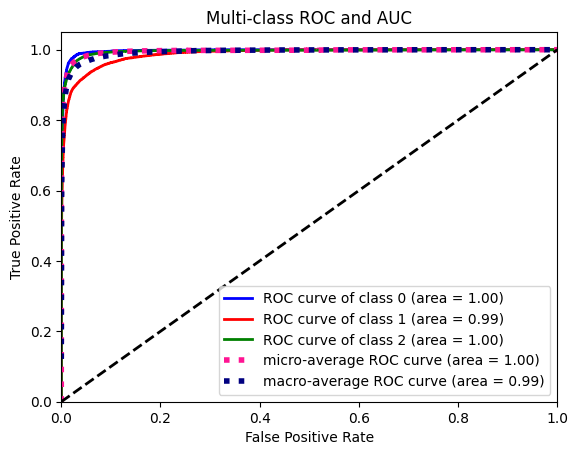

In [ ]:
y_prob = val_pred_probabilities.logits  # logits are the output probabilities

# True labels
val_true = np.concatenate([y.numpy() for x, y in val_datase_2], axis=0)
y_true_one_hot = tf.one_hot(val_true, depth=3)  # 3 classes

# Converting EagerTensor to NumPy array 
y_true_np = y_true_one_hot.numpy()

# This code was modified from code obtained from https://stackoverflow.com/questions/45332410/roc-for-multiclass-classification

# Compute ROC curve and ROC area for each class
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_np[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_np.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolating all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Averaging and computing AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC and AUC')
plt.legend(loc="lower right")
plt.show()



#### Sentiment Analysis with BERT Model and Out-Of-Domain testing

I utilized the fine-tuned BERT model to predict sentiments on both individual texts and a new dataset of hotel reviews. The process involved several steps: preprocessing text, converting it to BERT-compatible input format, making predictions, and analyzing these predictions.

First, I defined a function  predict_sentiment to predict sentiment for standalone reviews. I then preprocessed the hotel reviews dataset, converted the reviews into BERT input features, and used the model to predict sentiments for all reviews in the dataset.

After obtaining predictions, I compare the predicted sentiment labels with the actual sentiment derived from the review ratings. I used a confusion matrix and calculated the overall accuracy to evaluate the model's performance on this new dataset, offering insights into its generalizability and effectiveness in real-world scenarios.

In [ ]:
def predict_sentiment(text):
    # Tokenize and preprocess the text
    feature = convert_example_to_feature(text, label=0)  # label is not used here
    input_dict = {
        "input_ids": tf.constant([feature['input_ids']]),  # Wrap in list to match batch shape
        "attention_mask": tf.constant([feature['attention_mask']])  # Wrap in list to match batch shape
    }

    # Make a prediction
    predictions = model.predict(input_dict)
    sentiment = tf.argmax(predictions.logits, axis=1).numpy()[0]  # Get the index of the max logit

    # Map the prediction to the actual sentiment label
    sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    return sentiment_mapping[sentiment]

In [ ]:
print(predict_sentiment("This product was great!"))

1/1 [==============================] - 10s 10s/step
Positive


In [ ]:
print(predict_sentiment("It was a terrible experience using this product"))

1/1 [==============================] - 1s 504ms/step
Negative


In [ ]:
print(predict_sentiment("I am sort of inbetween with regards to this product"))

1/1 [==============================] - 1s 505ms/step
Neutral


In [ ]:
print(predict_sentiment("I have some mixed feelings about this product"))

1/1 [==============================] - 0s 500ms/step
Neutral


In [ ]:
print(predict_sentiment("My mind is not fully made up on this yet."))

1/1 [==============================] - 1s 505ms/step
Neutral


In [ ]:
Hotel_df=pd.read_csv('/content/drive/MyDrive/BERT SCRIPT/Datafiniti_Hotel_Reviews_Jun19.csv')

In [ ]:
Hotel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10000 non-null  object 
 1   dateAdded             10000 non-null  object 
 2   dateUpdated           10000 non-null  object 
 3   address               10000 non-null  object 
 4   categories            10000 non-null  object 
 5   primaryCategories     10000 non-null  object 
 6   city                  10000 non-null  object 
 7   country               10000 non-null  object 
 8   keys                  10000 non-null  object 
 9   latitude              10000 non-null  float64
 10  longitude             10000 non-null  float64
 11  name                  10000 non-null  object 
 12  postalCode            10000 non-null  object 
 13  province              10000 non-null  object 
 14  reviews.date          10000 non-null  object 
 15  reviews.dateAdded   

In [ ]:
Hotel_df['reviews.rating'].unique()

array([3, 4, 5, 2, 1])

In [ ]:
def rating_to_sentiment(rating):
    if rating <= 2:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

In [ ]:
# Applying the function to the 'review.rating' column to create a new 'sentiment_label' column
Hotel_df['sentiment_label'] = Hotel_df['reviews.rating'].apply(rating_to_sentiment)

In [ ]:
Hotel_df['sentiment_label'].unique()

array([1, 2, 0])

In [ ]:
# Map features to input format expected by BERT
def map_features_to_model_inputs_pred(features):
    inputs = {'input_ids': [], 'attention_mask': []}
    for feature in features:
        inputs['input_ids'].append(feature['input_ids'])
        inputs['attention_mask'].append(feature['attention_mask'])
    return inputs


# Function to convert examples to BERT features for prediction
def convert_example_to_feature_pred(review):
    # Encode the text using the BERT tokenizer
    encoding = tokenizer.encode_plus(
        review,
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length=512,          # Set maximum length to 512 tokens
        truncation=True,         # Truncate examples longer than 512 tokens
        padding='max_length',    # Pad shorter examples up to 512 tokens
        return_attention_mask=True  # Generate attention mask
    )
    # Return a dictionary with the encoded features
    return {
        'input_ids': encoding['input_ids'],
        'attention_mask': encoding['attention_mask']
    }


In [ ]:
# Converting the cleaned text to BERT features
bert_features = [convert_example_to_feature_pred(text) for text in Hotel_df['reviews.text']]

In [ ]:
# Using the function to convert the new features to BERT input format
new_inputs = map_features_to_model_inputs_pred(bert_features)

# Converting inputs to tensors
input_ids = tf.convert_to_tensor(new_inputs['input_ids'])
attention_masks = tf.convert_to_tensor(new_inputs['attention_mask'])

# Creating a TensorFlow dataset with batches
new_dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_masks)).batch(32)

predictions = model.predict(new_dataset)

# Converting predictions to labels
predicted_labels = np.argmax(predictions.logits, axis=1)

# Adding predictions to the new dataframe
Hotel_df['predicted_sentiment'] = predicted_labels

# Mapping numeric predictions back to sentiment labels
sentiment_label_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
Hotel_df['predicted_sentiment_label'] = Hotel_df['predicted_sentiment'].map(sentiment_label_mapping)


313/313 [==============================] - 30s 82ms/step


In [ ]:
Hotel_df['predicted_sentiment'].unique()

array([2, 0, 1])

In [ ]:
Hotel_df['predicted_sentiment_label'].unique()

array(['Positive', 'Negative', 'Neutral'], dtype=object)

In [ ]:
# Mapping from integer to string sentiment labels
int_to_str_sentiment = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

# Replacing integer labels with string labels in the DataFrame
Hotel_df['sentiment_label'] = Hotel_df['sentiment_label'].replace(int_to_str_sentiment)

In [ ]:
# Creating a cross-tabulation to compare actual and predicted sentiments
comparison = pd.crosstab(Hotel_df['sentiment_label'], Hotel_df['predicted_sentiment_label'])

accuracy = np.mean(Hotel_df['sentiment_label'] == Hotel_df['predicted_sentiment_label'])

In [ ]:
print(comparison)

predicted_sentiment_label  Negative  Neutral  Positive
sentiment_label                                       
Negative                        171      636       314
Neutral                          17      405       768
Positive                          9      519      7161


In [ ]:
print(f"Overall accuracy of sentiment prediction: {accuracy:.2f}")

Overall accuracy of sentiment prediction: 0.77


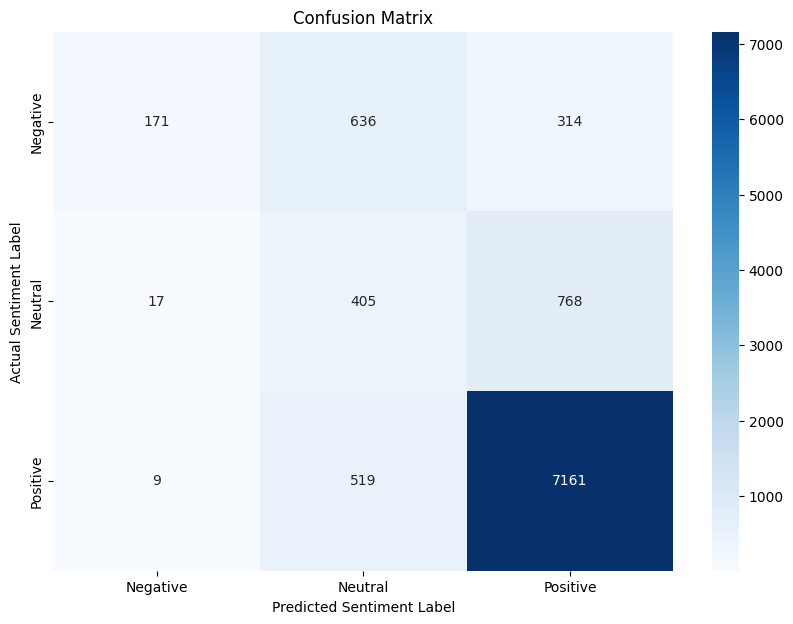

In [ ]:
# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(comparison, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Sentiment Label')
plt.ylabel('Actual Sentiment Label')
plt.show()

In [ ]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken to run the script: {total_time} seconds")

Total time taken to run the script: 15155.85490822792 seconds
